In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import *

import warnings
warnings.filterwarnings("ignore")

C:\Users\emir.e\Anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### First we obtain the top-3 largest volume cryptocurrencies from https://finance.yahoo.com/u/yahoo-finance/watchlists/crypto-top-volume-24hr/

In [2]:
# Download the data
BTC = yf.download("BTC-USD", start='2018-01-01', end='2024-01-01')['Adj Close']
ETH = yf.download("ETH-USD", start='2018-01-01', end='2024-01-01')['Adj Close']
USDT = yf.download("USDT-USD", start='2018-01-01', end='2024-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Obtain Log Returns
rBTC=(np.log(BTC).diff().dropna())*100
rETH=(np.log(ETH).diff().dropna())*100
rUSDT=(np.log(USDT).diff().dropna())*100

#### Apply t-test for mean of both log returns

In [4]:
# t-test for the mean. test value=0
t_rBTC, p_rBTC = stats.ttest_1samp(rBTC, 0)
print(t_rBTC , p_rBTC)

t_rETH, p_rETH = stats.ttest_1samp(rETH, 0) 
print(t_rETH , p_rETH)

t_rUSDT, p_rUSDT = stats.ttest_1samp(rUSDT, 0)  
print(t_rUSDT , p_rUSDT)

0.655690356057455 0.5120922807020449
0.4872630676759868 0.6261207066170682
-0.04475645304245292 0.9643055179695463


#### T-statistics for both BTC and ETH is relatively low and p-values are significantly higher than 0.05 threshold, meaning that dataset is not statistically significantly different from 0, implying no strong evidence of growth or decline over these periods.

#### However, USDT shows a negative t-statistic and a very high p-value. This result strongly indicates that the mean of the rUSDT dataset is not statistically different from 0. Since Tether (USDT) is a stablecoin, typically pegged to a currency like the USD, this result is expected and indicates that it's maintaining its value as designed.

In [5]:
# Checked up to 10 lags
acorr_ljungbox(rBTC, lags=[10])

,lb_stat,lb_pvalue
10,17.763719,0.059083


In [6]:
acorr_ljungbox(rETH, lags=[10])

,lb_stat,lb_pvalue
10,34.070799,0.00018


In [7]:
acorr_ljungbox(rUSDT, lags=[10])

,lb_stat,lb_pvalue
10,435.225265,2.955147e-87


#### Performing Ljung-Box test up to 10 lags to understand if there's any autocorrelation;
#### The Bitcoin time series shows borderline evidence of autocorrelation, suggesting a need for further analysis.
#### The Ethereum time series demonstrates strong evidence of autocorrelation.
#### The Tether time series shows extremely strong evidence of autocorrelation, possibly due to its nature as a stablecoin.

In [8]:
# Demeaned Returns
rD_BTC = rBTC - np.mean(rBTC)
rD_ETH = rETH - np.mean(rETH)
rD_USDT = rUSDT - np.mean(rUSDT)

In [9]:
acorr_ljungbox(rD_BTC**2, lags=[10])

,lb_stat,lb_pvalue
10,56.231009,1.858172e-08


In [10]:
acorr_ljungbox(rD_ETH**2, lags=[10])

,lb_stat,lb_pvalue
10,85.761239,3.693657e-14


In [11]:
acorr_ljungbox(rD_USDT**2, lags=[10])

,lb_stat,lb_pvalue
10,631.84432,2.632537e-129


#### The squared demeaned returns have a very low p-value, indicating strong autocorrelation in volatility. This supports using a GARCH model to capture the volatility clustering evident in both cryptocurrencies' returns.

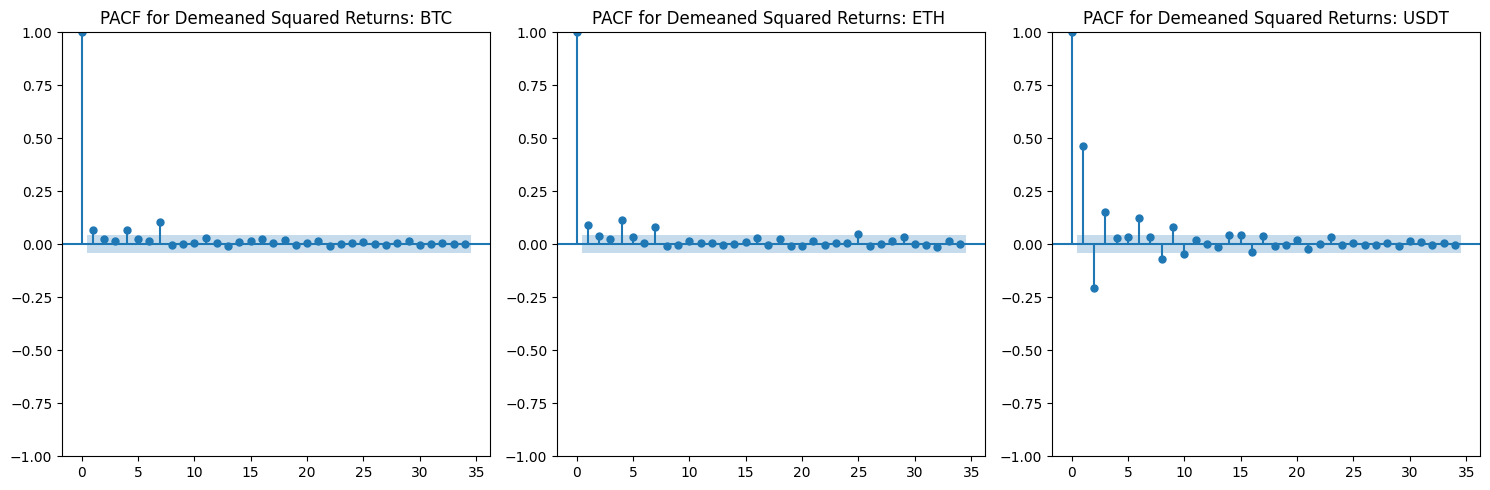

In [12]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot PACF for each dataset
plot_pacf(rD_BTC**2, ax=axs[0], title='PACF for Demeaned Squared Returns: BTC')
plot_pacf(rD_ETH**2, ax=axs[1], title='PACF for Demeaned Squared Returns: ETH ')
plot_pacf(rD_USDT**2, ax=axs[2], title='PACF for Demeaned Squared Returns: USDT')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

#### Significant cut-offs for BTC and ETH seem to happen in first lag, signifying that we should check an ARCH(1) model.
#### There are multiple seemingly significant lags beyond the first, but it's not clear without the confidence intervals. We will test ARCH(2) and ARCH(6) as well.

In [25]:
# ARCH(1) model estimation
BTC_AM1 = arch_model(rBTC, p=1, q=0, rescale=False)
BTC_res1 = BTC_AM1.fit(update_freq=0, disp='off')
print(BTC_res1.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5939.34
Distribution:                  Normal   AIC:                           11884.7
Method:            Maximum Likelihood   BIC:                           11901.7
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        10:20:01   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0628  7.687e-02      0.817      0.414 [-8.78

#### Error terms for BTC looks significant. Yet the p-value for mu suggests that the mean return is not significantly different from zero. Alpha[1] is greater than zero and shows statistical significance. Yet the high Akaine and Bayesian Information Criterion values suggest that ARCH(1) model may not be the best represantative of volatility in BTC returns. We might need to look for a GARCH model.
#### Also considering that BTC market is known for its high volatility and potentially non-normal distribution of returns, a model that assumes a normal distribution might not be the most appropriate for BTC. We should explore other distributions like Student's t or GED within the ARCH/GARCH framework.

In [24]:
ETH_AM1 = arch_model(rETH, p=1, q=0, rescale=False)
ETH_res1 = ETH_AM1.fit(update_freq=0, disp='off')
print(ETH_res1.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6493.90
Distribution:                  Normal   AIC:                           12993.8
Method:            Maximum Likelihood   BIC:                           13010.9
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        10:19:57   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0766  9.691e-02      0.791      0.429 [ -0.113,  0.26

#### Once again we cannot reject the null hypothesis on mu with high p-value. High AIC and BAC values also signal a room for improvement, by using higher lags or a GARCH model. 

In [15]:
rUSDT_AM1 = arch_model(rUSDT, p=1, q=0, rescale=False)
rUSDT_res1 = rUSDT_AM1.fit(update_freq=0, disp='off')
print(rUSDT_res1.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                74.0435
Distribution:                  Normal   AIC:                          -142.087
Method:            Maximum Likelihood   BIC:                          -125.012
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        09:41:15   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.0437e-03  6.516e-03      1.234      0.217 

In [20]:
rUSDT_AM2 = arch_model(rUSDT, p=2, q=0, rescale=False)
rUSDT_res2 = rUSDT_AM2.fit(update_freq=0, disp='off')
print(rUSDT_res2.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                392.208
Distribution:                  Normal   AIC:                          -776.415
Method:            Maximum Likelihood   BIC:                          -753.649
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        10:10:44   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.3962e-04  2.890e-03     -0.221      0.

In [23]:
rUSDT_AM6 = arch_model(rUSDT, p=6, q=0, rescale=False)
rUSDT_res6 = rUSDT_AM6.fit(update_freq=0, disp='off')
print(rUSDT_res6.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                929.512
Distribution:                  Normal   AIC:                          -1843.02
Method:            Maximum Likelihood   BIC:                          -1797.49
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        10:11:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.5046e-05  9.476e-04  3.699e-02      0.970 

C:\Users\emir.e\Anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [22]:
print(rUSDT_res1.aic, rUSDT_res1.bic)
print(rUSDT_res2.aic, rUSDT_res2.bic)
print(rUSDT_res6.aic, rUSDT_res6.bic)

-142.08691472035866 -125.01194425192702
-776.4152771010604 -753.6486498098182
-1843.0240943304243 -1797.4908397479398


#### Akaine and Bayesian Information Criteria (AIC and BAC) shows the measures with lowest values for ARCH(6) in USDT, but it shows high p-value in mu and higher lags show lesser significance. 
#### ARCH(2) model seems to be a good balance between model complexity and fit. It has significant coefficients for both lags, and although its log-likelihood is not as high as the ARCH(6) model, it is still significantly better than the ARCH(1) model. 
#### Yet we still have the issue with high p-value on mu for ARCH(2), yet another confirmation that we should look for GARCH models.
####  It is also worth noting that, for stablecoins, the absolute level of volatility may be less of a concern than for other cryptocurrencies, so the ARCH/GARCH modeling might be of more theoretical than practical interest.